# Workshop on *identifying individuals from picture library*

Contact: Low Yue Sheng

Email: e0545139@u.nus.edu

The workshop will be an attempt to complete one of my class quiz tasks

## Objective
In this workshop, we will perform the following three tasks
- Sorting pictures to 3 folders 1) Photo without faces, 2) Photo with more than 1 face, 3) Photo with 1 face 
- Cropping faces out of images based on face detection
- Verify subjects that are alone in photos against a database

## Dataset

- Create a folder for subject images
- Create a folder for one face images
- Create a folder for multiple face images
- Create a folder for no face images
- Create a folder for final output

## Steps taken

- Detect faces with haarcascade_frontalface_default.xml
  - If loop to sort photos into respective folders (one face, multiple faces, no face)
- Create and split face dataset for training of model
- Train person verification model
- Select picture from single face images and apply the person verification model to find subject




In [ ]:
# Check GPU setup in Colab
%tensorflow_version 1.x
import tensorflow as tf

# Silence the tensorflow warning message
tf.get_logger().setLevel('ERROR')

# Check GPU coinfiguration in Colab (T4 GPU)
print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())
# Your expected output will be '/device:GPU:0'


Tensorflow version:  1.15.2
/device:GPU:0


In [ ]:
# Mount your drive
# Run this cell, then you’ll see a link, click on that link, allow access
# Copy the code that pops up, Paste it in the box, Hit enter

from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder, please keep ''/content/gdrive/My Drive/XXX' in the path
# and change XXX to be your own folder. The pathname is case sensitive.
# Create 3 empthy folders in the tutorial folder as oneface, noface, multiplefaces
import os
os.chdir('/content/gdrive/My Drive/VSE/tutorial')
!ls


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 haarcascade_frontalface_default.xml   output_folder
 multiplefaces			       photos
 noface				       Reference
 oneface			      'Tutorial_Low Yue Sheng.ipynb'


## Importing the libraries

In [ ]:
import cv2
import sys
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

print("Versions of key libraries")
print("---")
print("cv2:       ", cv2.__version__)
print("numpy:     ", np.__version__)
print("matplotlib:", matplotlib.__version__)

Versions of key libraries
---
cv2:        4.1.2
numpy:      1.19.5
matplotlib: 3.2.2


## Sort pictures in folder


In [ ]:
def facedetect_to_sort(img,scaleFct=1.3,faceNbr=10):
  folder_path='/content/gdrive/My Drive/VSE/tutorial'
  os.chdir(folder_path)
  imgg=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  fce = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  face= fce.detectMultiScale(imgg,scaleFct,minNeighbors=faceNbr)
  dsp=img.copy()
  for (x,y,w,h) in face:
    cv2.rectangle(dsp,(x,y),(x+w,y+h),(255,255,255),2)
    fc=dsp[y:y+h,x:x+w]#cropped face
    cv2plt(dsp)
  return face


In [ ]:
def facedetect_then_crop(img,scaleFct=1.3,faceNbr=10):
  folder_path='/content/gdrive/My Drive/VSE/tutorial'
  os.chdir(folder_path)
  imgg=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  fce = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  face= fce.detectMultiScale(imgg,scaleFct,minNeighbors=faceNbr)
  dsp=img.copy()
  for (x,y,w,h) in face:
    cv2.rectangle(dsp,(x,y),(x+w,y+h),(255,255,255),2)
    fc=dsp[y:y+h,x:x+w]#cropped face
  return fc

In [ ]:
#change directory to image folder
folder_path='/content/gdrive/My Drive/VSE/tutorial/photos'
os.chdir(folder_path)
print("Current working directory:")
os.getcwd()

Current working directory:


'/content/gdrive/My Drive/VSE/tutorial/photos'

In [ ]:
dirs = sorted(os.listdir(folder_path))
print("Total number of photos in the full folder: ", len(dirs))

Total number of photos in the full folder:  45


In [ ]:
#change directory to image folder
path1 = "/content/gdrive/My Drive/VSE/tutorial/noface"
path2 = "/content/gdrive/My Drive/VSE/tutorial/oneface"
path3 = "/content/gdrive/My Drive/VSE/tutorial/multiplefaces"
for img in np.arange(len(dirs)):
  os.chdir(folder_path)
  imgg=cv2.imread(dirs[img])
  if facedetect_then_sort(imgg)==():
    os.chdir(path1)
    cv2.imwrite(dirs[img],imgg)
  elif facedetect_then_sort(imgg).shape[0]==1:
    cropped_face=facedetect_then_crop(imgg)
    os.chdir(path2)
    cv2.imwrite(dirs[img],cropped_face)
  else:
    os.chdir(path3)
    cv2.imwrite(dirs[img],imgg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [ ]:
# Load library
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Dot, Conv2D, MaxPool2D, Flatten
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline


[link text](https://)# Explore face dataset

The Reference folder consists of folders corresponding to interested parties. The folder name is the name of the person.

First, we map each class (identity) to an integer id, and build mappings as dictionaries.
- mappings from person name (folder name) and class id: `name_to_classid` and `classid_to_name`

Furthermore, in each folder, there is one or more images corresponding to the identity. We map each image path with an integer id, then build a few dictionaries
- mappings from imagepath and image id: `path_to_imageid` and `imageid_to_path`
- mappings from class id to image id: `classid_to_imageid` and `imageid_to_classid`

Summary 
- name: person name, folder name
- classid: integer number to indicate the person name
- path: path to save the person images
- imageid: integer number to indicate the image file index

In [ ]:
# Code adapted from class tutorial
# Define the path for the downloaded images, using partial lfw dataset
PATH = "/content/gdrive/My Drive/VSE/tutorial/Reference/"
# Select subset of dataset as per class
USE_SUBSET = True
dirs = sorted(os.listdir(PATH))
print("Total number of classes (persons) in the full dataset: ", len(dirs))
if USE_SUBSET:
    dirs = dirs[:261]
print("Total number of classes (persons) in workshop: ", len(dirs))
# Build two dictionaries
name_to_classid = {d: i for i, d in enumerate(dirs)}
classid_to_name = {v: k for k, v in name_to_classid.items()}
# read all directories
img_paths = {c: [PATH + subfolder + "/" + img
                 for img in sorted(os.listdir(PATH + subfolder))] 
             for subfolder, c in name_to_classid.items()}
# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_imageid = {v: k for k, v in enumerate(all_images_path)}
imageid_to_path = {v: k for k, v in path_to_imageid.items()}

# build mappings between images and class
classid_to_imageid = {k: [path_to_imageid[path] for path in v] for k, v in img_paths.items()}
imageid_to_classid = {v: c for c,imgs in classid_to_imageid.items() for v in imgs}

Total number of classes (persons) in the full dataset:  261
Total number of classes (persons) in workshop:  261


# Prepare dataset to train a deep learning model for person verification

- Build pairs of positive and negative training images
- Split dataset into train and test subsets for model training


In [ ]:
# build pairs of positive image ids for a given classid
def build_pos_pairs_for_imageid(classid, max_num=50):
    imgs = classid_to_imageid[classid]
    if len(imgs) == 1:
        return []
    pos_pairs = [(imgs[i], imgs[j])
                 for i in range(len(imgs))
                 for j in range(i + 1, len(imgs))]
    #random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

# build pairs of negative image ids for a given classid
def build_neg_pairs_for_imageid(classid, classes, max_num=20):
    imgs = classid_to_imageid[classid]
    neg_classes_imageid = random.sample(classes, max_num+1)
    if classid in neg_classes_imageid:
        neg_classes_imageid.remove(classid)
    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0,len(imgs)-1)]
        imgs2 = classid_to_imageid[neg_classes_imageid[id2]]
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]
    return neg_pairs

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        temp = cv2.imread(path)
        temp = cv2.resize(temp, (100, 100))        
        all_imgs += [np.expand_dims(temp,0)]
    return np.vstack(all_imgs)

def build_train_test_data(num_classes, split=0.8):
    listX1 = []
    listX2 = []
    listY = []
    split = int(num_classes * split)
    
    # train
    for id in range(split):
        pos = build_pos_pairs_for_imageid(id)
        neg = build_neg_pairs_for_imageid(id, list(range(split)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    perm = np.random.permutation(len(listX1))
    X1_ids_train = np.array(listX1)[perm]
    X2_ids_train = np.array(listX2)[perm]
    Y_ids_train = np.array(listY)[perm]
    
    listX1 = []
    listX2 = []
    listY = []
    
    #test
    for id in range(split, num_classes):
        pos = build_pos_pairs_for_imageid(id)
        neg = build_neg_pairs_for_imageid(id, list(range(split, num_classes)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_test = np.array(listX1)
    X2_ids_test = np.array(listX2)
    Y_ids_test = np.array(listY)
    return (X1_ids_train, X2_ids_train, Y_ids_train,
            X1_ids_test, X2_ids_test, Y_ids_test)

class Generator:

    def __init__(self, X1, X2, Y, batch_size, all_imgs):
        self.cur_train_index=0
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]
        
    def next_train(self):
        while 1:
            self.cur_train_index += self.batch_size
            if self.cur_train_index >= self.num_samples:
                self.cur_train_index=0
            
            imgs1 = self.X1[self.cur_train_index:self.cur_train_index+self.batch_size]
            imgs2 = self.X2[self.cur_train_index:self.cur_train_index+self.batch_size]

            yield ([self.imgs[imgs1], self.imgs[imgs2]],
                    self.Y[self.cur_train_index:self.cur_train_index+self.batch_size])


In [ ]:
# Generate training imageid index and test imageid index
num_classes = len(name_to_classid) # Total number of persons used in this workshop
X1_ids_train, X2_ids_train, train_Y, X1_ids_test, X2_ids_test, test_Y = build_train_test_data(num_classes)

# Open all images
all_imgs = open_all_images(imageid_to_path)
print('Total images: ', all_imgs.shape)

# Define an image dataloader
gen = Generator(X1_ids_train, X2_ids_train, train_Y, 32, all_imgs)
[x1, x2], y = next(gen.next_train())

# Prepare test image subset
test_X1 = all_imgs[X1_ids_test]
test_X2 = all_imgs[X2_ids_test]


Total images:  (583, 100, 100, 3)




```
# This is formatted as code
```

#Design and train a person verification model

Objectives: Build a convolutional model. Warning: Large convolutions on high dimensional images can be very slow on CPUs.

In [ ]:
# Define the loss function
def contrastive_loss(y_true, y_pred, margin=0.25):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    return K.mean( y_true * K.square(1 - y_pred) +
                  (1 - y_true) * K.square(K.maximum(y_pred - margin, 0)))

def accuracy_sim(y_true, y_pred, threshold=0.7):
    '''Compute classification accuracy with a fixed threshold on similarity.
    '''
    y_thresholded = K.cast(y_pred > threshold, y_true.dtype)
    return K.mean(K.equal(y_true, y_thresholded))


In [ ]:
#Define a model
inp = Input((100, 100, 3), dtype='float32')
x = Conv2D(16, 3, activation="relu", padding="same")(inp)
x = Conv2D(16, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x)
x = Flatten()(x)
x = Dense(50)(x)
shared_conv = Model(inputs=inp, outputs=x)

print('Input: ', all_imgs.shape)
print('Output: ', shared_conv.predict(all_imgs).shape)

shared_conv.summary()


Input:  (583, 100, 100, 3)
Output:  (583, 50)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 16)      2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2000050   
Total params: 2,002,818
Trainable params: 2,002,818
Non-trainable params: 0
___

In [ ]:
# Define the siamese model
i1 = Input((100, 100, 3), dtype='float32')
i2 = Input((100, 100, 3), dtype='float32')

x1 = shared_conv(i1)
x2 = shared_conv(i2)

out = Dot(axes=-1, normalize=True)([x1, x2])

model = Model(inputs=[i1, i2], outputs=out)
model.compile(loss=contrastive_loss, optimizer='rmsprop', metrics=[accuracy_sim])

model.summary()


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
model_7 (Model)                 (None, 50)           2002818     input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
dot_3 (Dot)                     (None, 1)            0           model_7[1][0]              

In [ ]:
# Train the model, set smaller epoch if you don't have GPU

NUM_EPOCH = 40
hist = model.fit_generator(generator=gen.next_train(), steps_per_epoch=train_Y.shape[0] // 32, epochs=NUM_EPOCH, validation_data=([test_X1, test_X2], test_Y), verbose=1)


Epoch 1/40
29/29 [==============================] - 2s 54ms/step - loss: 0.1748 - accuracy_sim: 0.5905 - val_loss: 0.2017 - val_accuracy_sim: 0.5079
Epoch 2/40
29/29 [==============================] - 1s 39ms/step - loss: 0.0672 - accuracy_sim: 0.8082 - val_loss: 0.1434 - val_accuracy_sim: 0.5749
Epoch 3/40
29/29 [==============================] - 1s 24ms/step - loss: 0.0243 - accuracy_sim: 0.9375 - val_loss: 0.1978 - val_accuracy_sim: 0.5700
Epoch 4/40
29/29 [==============================] - 1s 23ms/step - loss: 0.0149 - accuracy_sim: 0.9591 - val_loss: 0.2027 - val_accuracy_sim: 0.5458
Epoch 5/40
29/29 [==============================] - 1s 24ms/step - loss: 0.0047 - accuracy_sim: 0.9925 - val_loss: 0.2627 - val_accuracy_sim: 0.5410
Epoch 6/40
29/29 [==============================] - 1s 24ms/step - loss: 0.0041 - accuracy_sim: 0.9903 - val_loss: 0.2802 - val_accuracy_sim: 0.5487
Epoch 7/40
29/29 [==============================] - 1s 24ms/step - loss: 0.0038 - accuracy_sim: 0.9957 - v

#Apply the person verification model to find subject from cropped images folder


Tasks

- Randomly select a query image, from cropped single face folder
- Evaluate the similairty using the pre-trained siamese model
- Save similiarity>0.95 in output_folder

In [ ]:
# Load cropped images
path2 = "/content/gdrive/My Drive/VSE/tutorial/oneface"
os.chdir(path2)
dirs = sorted(os.listdir(path2))
print("Total number of photos in the full folder: ", len(dirs))

for img in np.arange(len(dirs)):
  os.chdir(path2)
  query_image=cv2.imread(dirs[img])
  # Extract features using the pre-trained siamese model,# Normalize features and calculate their cosine similarity distance
  query_image = cv2.resize(query_image, (100, 100))
  query_image_coeff = shared_conv.predict(np.expand_dims(query_image, 0))
  similarity_matrix=[]
  for i in imageid_to_path:
    comparison_image=cv2.imread(imageid_to_path[i])
    comparison_image=cv2.resize(comparison_image, (100, 100))
    comparison_coeff = shared_conv.predict(np.expand_dims(comparison_image, 0))
    similarity_matrix.append(np.inner(query_image_coeff/np.linalg.norm(query_image_coeff), comparison_coeff/np.linalg.norm(comparison_coeff)))
  similarity_list=[]
  counter=0
  for i in similarity_matrix:
    similarity_list.append(similarity_matrix[counter][0][0])
    counter+=1
  similarity_list
  idx=np.argsort(similarity_list)[-1]
  if similarity_list[idx]>0.95:
    output_path='/content/gdrive/My Drive/VSE/tutorial/output_folder'
    os.chdir(output_path)
    cv2.imwrite(dirs[img],query_image)

Total number of photos in the full folder:  11


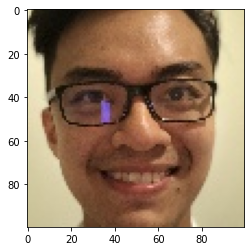

In [ ]:
import matplotlib.pyplot as plt
os.chdir(output_path)
img_check=cv2.imread(os.listdir(output_path)[0])
plt.figure()
plt.imshow(cv2.cvtColor(img_check,cv2.COLOR_BGR2RGB)/255) 